# Project Milestone 3

Barbenheimer was an interesting phenomenon of summer 2023. It was so impactful that it even shook the US economy alongside Taylor Swift and Beyoncé ([link](https://www.investopedia.com/beyonce-taylor-swift-barbenheimer-boosted-summer-spending-7964698)). Interestingly enough, Barbie performed better than Oppenheimer in terms of grossing but not in the ratings. In this notebook, we are investigating how "Barbie-like" movies fare against "Oppenheimer-like" movies historically. Who would prevail if both movies had been released at another time?

____________________________________________________________

# Sections

 . [Loading Data](#Loading-Data)\
 . [Primary Investigations and Data Processing](#Primary-Investigations-and-Data-Processing)

_____________________________________

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from textblob import TextBlob
import ast
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Loading Data

In this section, we will use the csv document that was generated in in milestone P2 rather than the CMU movie corpus dataset as it contains the data of the initial dataset combined with ratings from IMDB. We will also load the character data and the plot summaries.

In [211]:
#data paths
MOVIES_PATH = "./data/MovieSummaries/movies.imdbrating.tsv"

CHARACTERS_PATH = "./data/MovieSummaries/character.metadata.tsv"

SUMMARIES_PATH = "./data/MovieSummaries/plot_summaries.txt"

BARBENHEIMER_MOVIE_PATH = "./data/MovieSummaries/Barbenheimer.csv"

In [216]:
#Barbie and Oppenheimer data
barbieoppenheimermoviedf = pd.read_csv(BARBENHEIMER_MOVIE_PATH)

barbieoppenheimermoviedf.head(2)

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_year_released,NaN_per_row,titleId,ordering,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,55436290.0,NaN,Barbie,6/9/2023,1.442000e+09,114.0,['English Language'],"['United States of America', 'United Kingdom']","['Adventure', 'Comedy', 'Fantasy']",2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,398227.0
1,108839994.0,NaN,Oppenheimer,6/9/2023,9.532000e+08,181.0,['English Language'],"['United States of America', 'United Kingdom']","['Biography', 'Drama', 'Thriller']",2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.4,540216.0


In [4]:
#Column names
characters_columns = ["Wikipedia_movie_ID",
                      "Freebase_movie_ID",
                      "Movie_release_date",
                      "Character_name",
                      "Actor_date_of_birth", 
                      "Actor_gender", 
                      "Actor_height", 
                      "Actor_ethnicity", 
                      "Actor_name", 
                      "Actor_age_at_movie_release", 
                      "Freebase_character_actor_map_ID", 
                      "Freebase_character_ID", 
                      "Freebase_actor_ID"]

plot_columns = ["Wikipedia_movie_ID",
                "Plot"]

In [5]:
#movies dataframe: shape and head
moviesdf = pd.read_csv(MOVIES_PATH, sep="\t")
print(f"Shape of movies dataframe: {moviesdf.shape}")
moviesdf.head(3)

Shape of movies dataframe: (81690, 20)


,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_year_released,NaN_per_row,titleId,ordering,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,['English Language'],['United States of America'],"['Action', 'Supernatural', 'Space western', 'A...",2001.0,0,tt0228333,11.0,FR,NaN,NaN,NaN,0.0,4.9,56867.0
1,1148228,/m/04bfqy,calamity jane,1953-11-04,2500000.0,97.0,['English Language'],['United States of America'],"['Comedy', 'Biography', 'Western', 'Musical', ...",1953.0,0,tt0045591,15.0,RO,NaN,imdbDisplay,NaN,0.0,7.2,10568.0
2,1039561,/m/040ntm,heavy weights,1995-02-17,17689177.0,100.0,['English Language'],['United States of America'],"['Comedy-drama', 'Comedy', 'Family Film', 'Sla...",1995.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#characters dataframe: shape and head
charactersdf = pd.read_csv(CHARACTERS_PATH, sep='\t', header=None, names=characters_columns)
print(f"Shape of characters dataframe: {charactersdf.shape}")
charactersdf.head(3)

Shape of characters dataframe: (450669, 13)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [7]:
#plots dataframe: shape and head
plotsdf = pd.read_csv(SUMMARIES_PATH, sep = "\t", header=None, names=plot_columns)
print(f"Shape of plots dataframe: {plotsdf.shape}")
plotsdf.head(3)

Shape of plots dataframe: (42303, 2)


,Wikipedia_movie_ID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...


___________________

# Primary Investigations and Data Processing

In this section, we will conduct some preliminary analysis on the data: plot the number of movies over the years, the total number of genres, their distribution and their popularity.

### Global yearly analysis

In this section, we will just analyze the whole dataset as it evolves over the years, looking at number of movies released, genres per year, income, average ratings and number of ratings.

In [8]:
#percentage of missing years
percentmissingyears = moviesdf["Movie_year_released"].isna().sum()/len(moviesdf["Movie_year_released"])*100
print(f"The percentage of missing release years is: {percentmissingyears}%")

The percentage of missing release years is: 8.409842085934631%


Text(0.5, 1.0, 'Number of movies released over the years')

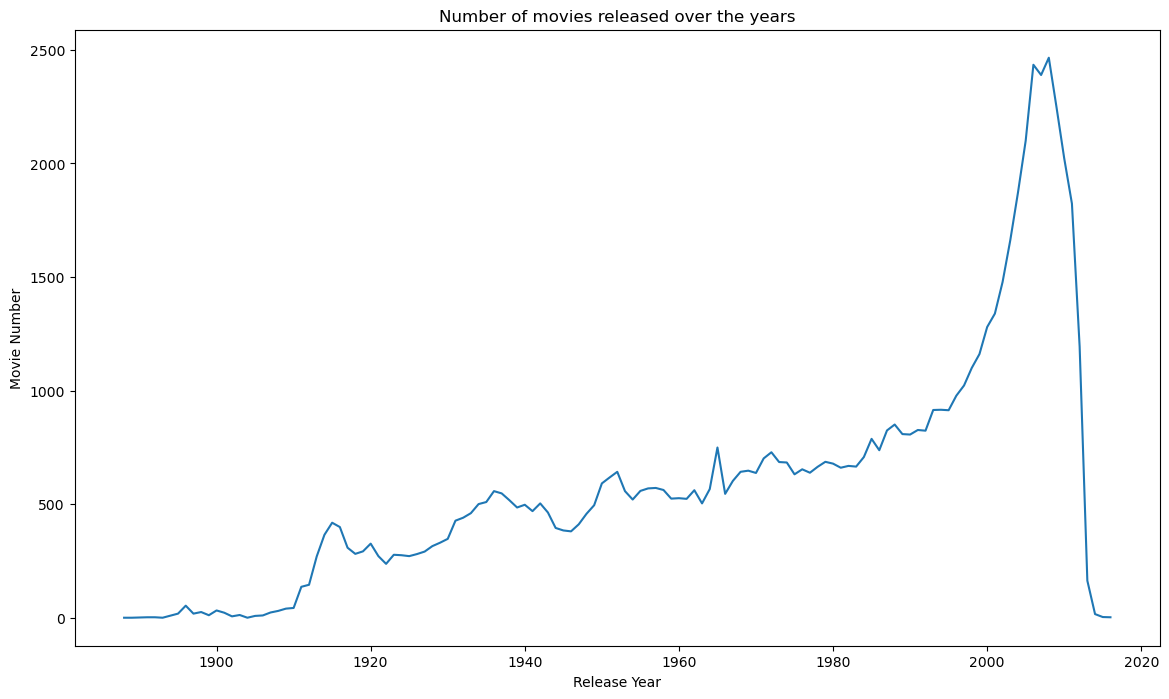

In [9]:
#number of movies released per year
moviesperyear = moviesdf.groupby("Movie_year_released").size()

plt.figure(figsize = (14,8))
sns.lineplot(moviesperyear)
plt.xlabel("Release Year")
plt.ylabel("Movie Number")
plt.title("Number of movies released over the years")

**Comment:** we already see a first error in the dataset: some movies have been released after 2012 (the dataset is from 2012). We are also missing roughly 8.4% of the values in the release year column. \
**Solution:** we filter them out. The information loss in this case is insignificant especially since the veracity of those fields is questionable.

In [10]:
#filter out movies released after 2013
moviesdf = moviesdf[moviesdf["Movie_year_released"]<2013]
print(f"Shape of movie dataframe after removing movies with wrong release date: {moviesdf.shape}")

Shape of movie dataframe after removing movies with wrong release date: (74632, 20)


_____

### Yearly Income and Ratings Analysis

In this subsection we will look at popularity over the entire dataset: the number of ratings over time and the grossing.

Text(0.5, 1.0, 'Revenue of Movies over the years')

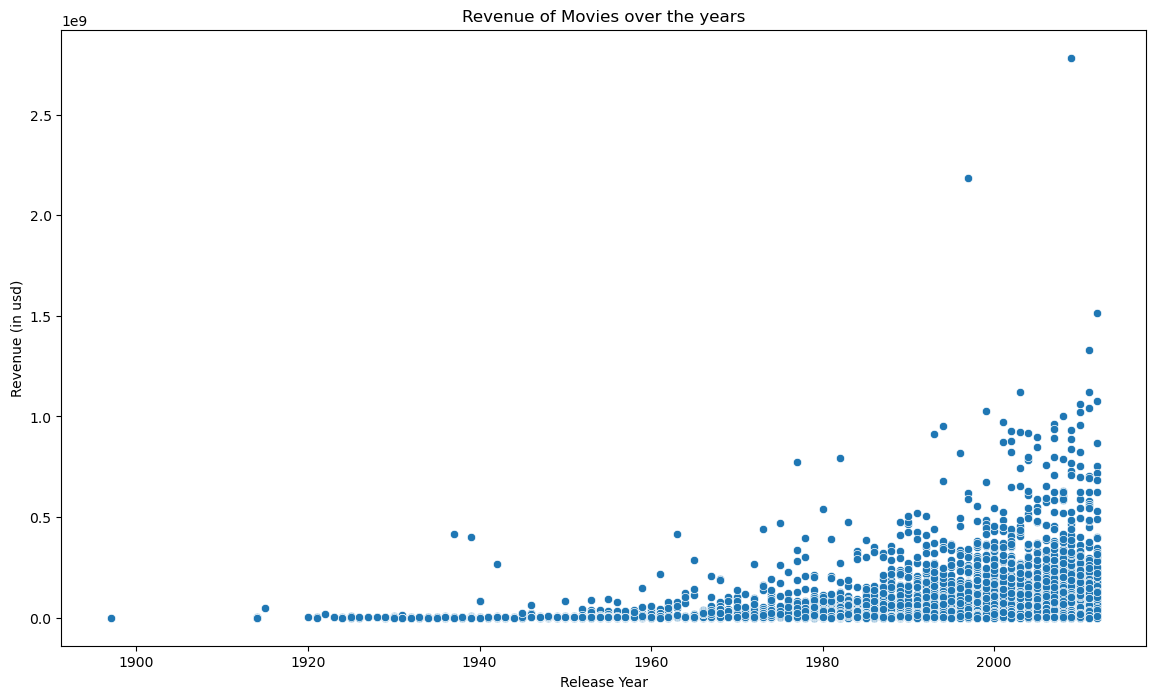

In [11]:
#plot the grossing over time
plt.figure(figsize=(14,8))
sns.scatterplot(data=moviesdf, x="Movie_year_released", y="Movie_box_office_revenue")
plt.xlabel("Release Year")
plt.ylabel("Revenue (in usd)")
plt.title("Revenue of Movies over the years")

In [12]:
#get number of movies without revenues
number_of_zero_revenues = (moviesdf["Movie_box_office_revenue"]==0).sum()
nan_revenues = moviesdf["Movie_box_office_revenue"].isna().sum()

print(f"Number of movies where the revenue is 0: {number_of_zero_revenues}")
print(f"Number of movies where the revenue is Nan: {nan_revenues}")

#before the 1960s
movies_before_sixties = moviesdf[moviesdf["Movie_year_released"]<1960]
number_of_zero_revenues_before_sixty = (movies_before_sixties["Movie_box_office_revenue"]==0).sum()
nan_revenues_before_sixty = movies_before_sixties["Movie_box_office_revenue"].isna().sum()

print(f"\n Number of movies released before 1960: {len(movies_before_sixties.index)}")
print(f"Before 1960, number of movies where the revenue is 0: {number_of_zero_revenues_before_sixty}")
print(f"Before 1960, number of movies where the revenue is Nan: {nan_revenues_before_sixty}")

Number of movies where the revenue is 0: 0
Number of movies where the revenue is Nan: 66305

 Number of movies released before 1960: 20878
Before 1960, number of movies where the revenue is 0: 0
Before 1960, number of movies where the revenue is Nan: 19810


**Comment:** It seems that we have no revenue information for the vast majority of movie and more especially older movies. For instance, if we look before the 1960s, out of 20878 movies, we do not have the revenue of 19810. We also observe some outliers such as Avatar for example with its whopping 2.92 billion usd revenue. We will not remove movies without information on their revenue for now. But we will remove Avatar and other outlier grossing more than 2 billions.

In [13]:
#remove grossing outlier
moviesdf["Movie_box_office_revenue"].fillna(0, inplace=True)
moviesdf = moviesdf[moviesdf["Movie_box_office_revenue"]<2000000000]

#restore the nans
moviesdf["Movie_box_office_revenue"].replace(0, np.nan, inplace=True)

_____

### General Genres Analysis

In this subsection we look at genres. This will give us a better idea of how we have to direct our future investigations.

In [14]:
#interpret the list of genres as actual lists
moviesdf["Movie_genres"] = moviesdf["Movie_genres"].apply(ast.literal_eval)

#find number of genres per movies
moviesdf["GenreNumber"] = moviesdf["Movie_genres"].apply(len)

#make dictionary of all genres to count them
genre_counts = {}

#make dictionary of unique genres per year and one to count genres 
yearly_unique_genres = {}
yearly_genre_count = {}

#loop over all rows
for _, row in moviesdf.iterrows():
    year = row["Movie_year_released"]
    genres = row["Movie_genres"]
    
    #check if year in dictionary already
    if not(year in yearly_unique_genres.keys()):
        yearly_unique_genres[year] = set()
        yearly_genre_count[year] = []
    
    #append list of genres
    yearly_unique_genres[year].update(genres)
    yearly_genre_count[year].append(len(genres))
    
    #update dictionary
    for genre in genres:
        genre_counts[genre] = genre_counts.get(genre, 0) + 1
    

#compile all results in a separate dictionary
investigative_genres_df={}

#populate result dictionary
for year in yearly_unique_genres.keys():
    investigative_genres_df[year] = {"Nb_unique_genres": len(yearly_unique_genres[year]),
                                   "Mean_genre_nb": np.mean(yearly_genre_count[year]),
                                   "Std_genre": np.std(yearly_genre_count[year])}

#convert to dataframe
investigative_genres_df = pd.DataFrame(investigative_genres_df).transpose().reset_index()
investigative_genres_df.rename(columns={'index': 'MovieYear'}, inplace=True)

In [15]:
investigative_genres_df.head()

,MovieYear,Nb_unique_genres,Mean_genre_nb,Std_genre
0,2001.0,229.0,3.904406,2.555400
1,1953.0,123.0,2.629032,1.700838
2,1995.0,186.0,3.669584,2.465121
3,2002.0,219.0,3.858593,2.462087
4,1992.0,183.0,3.292476,2.382815


In [16]:
#print all genres from least to most recurrent
print(f"Total number of genres: {len(genre_counts.keys())}")
#Sort for recurrence
lowest_counts = sorted(genre_counts.items(), key=lambda x: x[1])
print("\nGenres in ascending recurrence:")
for genre, count in lowest_counts:  
    print(f"{genre}: {count}")

Total number of genres: 363

Genres in ascending recurrence:
Comdedy: 1
Breakdance: 1
Statutory rape: 1
Chick flick: 1
Buddy Picture: 1
Homoeroticism: 1
New Queer Cinema: 1
Neorealism: 1
War effort: 1
Silhouette animation: 1
C-Movie: 1
Linguistics: 1
Romantic thriller: 1
Ninja movie: 2
Private military company: 2
Period Horror: 2
Star vehicle: 2
Revisionist Fairy Tale: 2
The Netherlands in World War II: 2
Patriotic film: 2
Political Documetary: 2
Beach Party film: 2
Conspiracy fiction: 2
Prison escape: 2
Revenge: 2
Vampire movies: 3
Live action: 3
Camp: 3
Supermarionation: 3
Point of view shot: 3
Bruceploitation: 3
Expressionism: 3
Tokusatsu: 3
Nuclear warfare: 3
Z movie: 3
Werewolf fiction: 4
Cyberpunk: 4
Humour: 4
Therimin music: 4
Goat gland: 4
Race movie: 4
Film-Opera: 4
Female buddy film: 5
Bloopers & Candid Camera: 5
Psychological horror: 5
Plague: 5
Sci-Fi Thriller: 5
Outlaw: 5
Space opera: 5
Libraries and librarians: 5
School story: 5
Coming-of-age film: 5
Historical Documentar

We have an overview of all of the above genres. Obviously, drama, comedy, romance, action, thriller and adventure are kings. Horror is also up there. Interestingly, it seems that we have quite the many silent and black and white movies. Another genre which is not necessarily a genre is `World Cinema` which itself is used to refer to movies that were made out of the american motion picture industry. \
**Comment:** Some genres appear only once and there is even 1 movie where comedy was written as a typo (see comdedy above) \
**Problem:** Some genres are the same or are made of fusion genres (ie: ealing comedies, romantic drama ...) In that case we will delete those genres and split them into their respective supergenres.\
**Solution:** Correct the comdedy mistake. when creating a onehot of genres, we will just split . With regards to rare genres it doesn't really matter as long as they share a genre similar to barbie or oppenheimer.

Text(0.5, 1.0, 'Number of unique genre released per year')

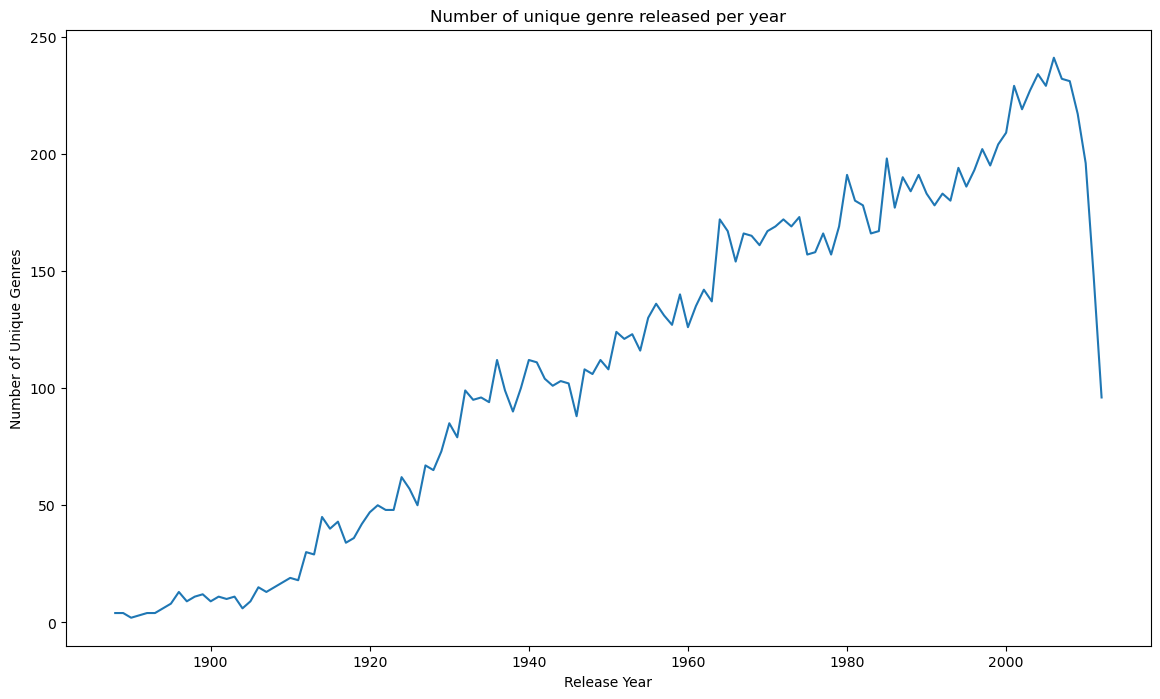

In [17]:
#plot number of genres released per year
plt.figure(figsize=(14,8))
sns.lineplot(data=investigative_genres_df, x="MovieYear", y="Nb_unique_genres")
plt.xlabel("Release Year")
plt.ylabel("Number of Unique Genres")
plt.title("Number of unique genre released per year")

Text(0.5, 1.0, 'Average number of genre per movie over the years (error bar is standard deviation from mean)')

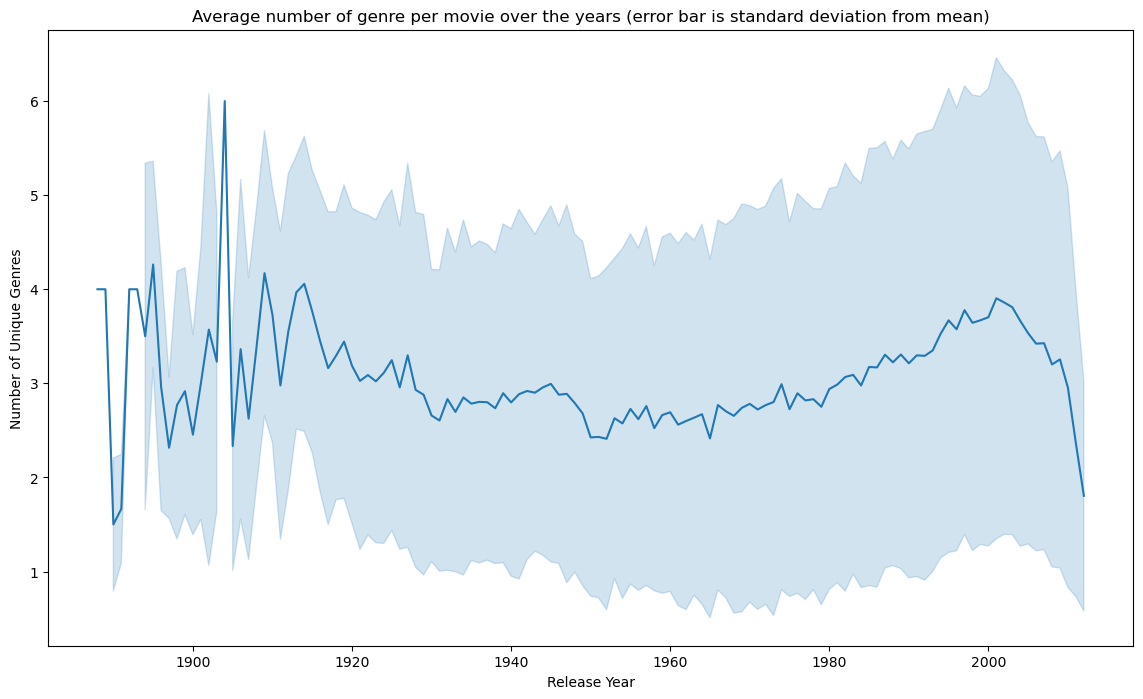

In [18]:
#Plot aerage number of genres per movie per year
plt.figure(figsize=(14,8))
sns.lineplot(data=moviesdf, x="Movie_year_released", y="GenreNumber", errorbar = "sd")
plt.xlabel("Release Year")
plt.ylabel("Number of Unique Genres")
plt.title("Average number of genre per movie over the years (error bar is standard deviation from mean)")

Text(0.5, 1.0, 'Distributtion of the number of genres')

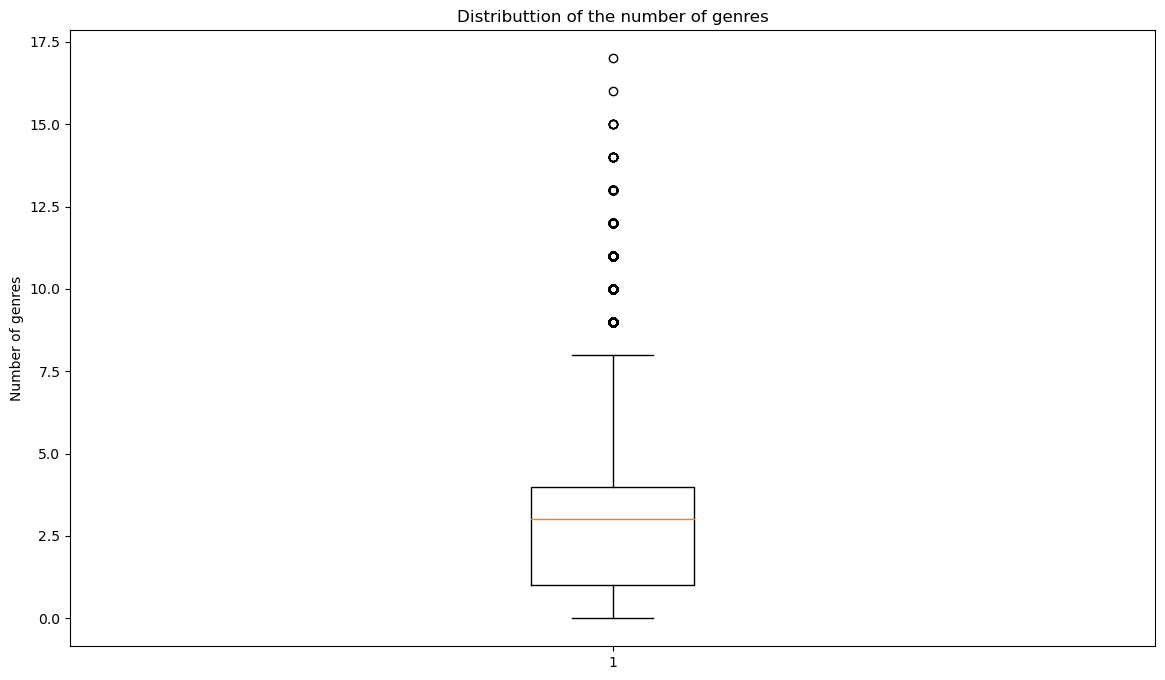

In [19]:
#Plot distribution of the number of genre
plt.figure(figsize=(14,8))
plt.boxplot(moviesdf["GenreNumber"])
plt.ylabel("Number of genres")
plt.title("Boxplot of the number of genres")

In [20]:
#number of movies with no genres
(moviesdf["GenreNumber"]==0).sum()

1749

In [21]:
#number of movies with more than 10 genres
(moviesdf["GenreNumber"]>10).sum()

315

**Comment:** Looking at the number of genres released over the years, it seems that this number is always increasing except for more recent years. Looking at the standard deviation and average, we see that in recent years, it seems movie had 1 or 2 genres only.
Further looking at the box plot, we see the existence of some outliers, notably a 17 genres movie. \
Finally, we also have movies with 0 genres. \
**Solution:** Delete the movies without genres, we loose 1749 from the movies with no genres. The outliers with more than 10 genres (315 movies) will be discarded as they pause too great of a risk of overlap with both Barbie and Oppenheimer. We may discard the ones with more than 8 in the future if they overlap too much with both Barbie and Oppenheimer.

In [22]:
#filter out movies without any genre
moviesdf = moviesdf[~(moviesdf["GenreNumber"]==0)]

#remove movies with more than 10 genres
moviesdf = moviesdf[moviesdf["GenreNumber"]<=10]

___________________________

### Investigative plot analysis

In this section, we will look at plots: their length, their number of word and their positive, negative and overall sentiment. Since our analysis will be mostly plot centered, this section could be considered crucial to our project.

In [23]:
#print the plots dataframe to remember it more clearly
plotsdf.head()

,Wikipedia_movie_ID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


We will start by counting the number the number of sentences and the number of words in the plots. This would give us an idea of how much information we can gather and how many plots we have to discard due to low information potential.

When using spaCy, we will limit ourselves to the small model because in terms of performance it is adequate for our current use case without having us use the larger ones.

In [25]:
#load spacy model as natural language processor
nlprocessor = spacy.load("en_core_web_sm")

In [26]:
#list of helper functions that will be useful

#count sentences in a given plot
def count_sentences(plot):
    doc = nlprocessor(plot)
    sentences = list(doc.sents)
    return len(sentences)

#counts the number of words
def count_words(plot, ignorepunct = True):
    doc = nlprocessor(plot)
    if ignorepunct:
        words = [token.text for token in doc if not token.is_punct]
    else:
        words = [token.text for token in doc]
    return len(words)

In [28]:
%%time
#get and word number in each plot
plotsdf["Sentence_num"] = plotsdf["Plot"].apply(count_sentences)
plotsdf["Word_num"] = plotsdf["Plot"].apply(count_words)

CPU times: total: 16min 54s
Wall time: 1h 20min 55s


In [29]:
#store the dataframe in case of mishap
%store plotsdf

Stored 'plotsdf' (DataFrame)


In [30]:
plotsdf.head()

,Wikipedia_movie_ID,Plot,Sentence_num,Word_num
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",1,28
1,31186339,The nation of Panem consists of a wealthy Capi...,52,791
2,20663735,Poovalli Induchoodan is sentenced for six yea...,26,501
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",49,870
4,595909,Seventh-day Adventist Church pastor Michael Ch...,15,408


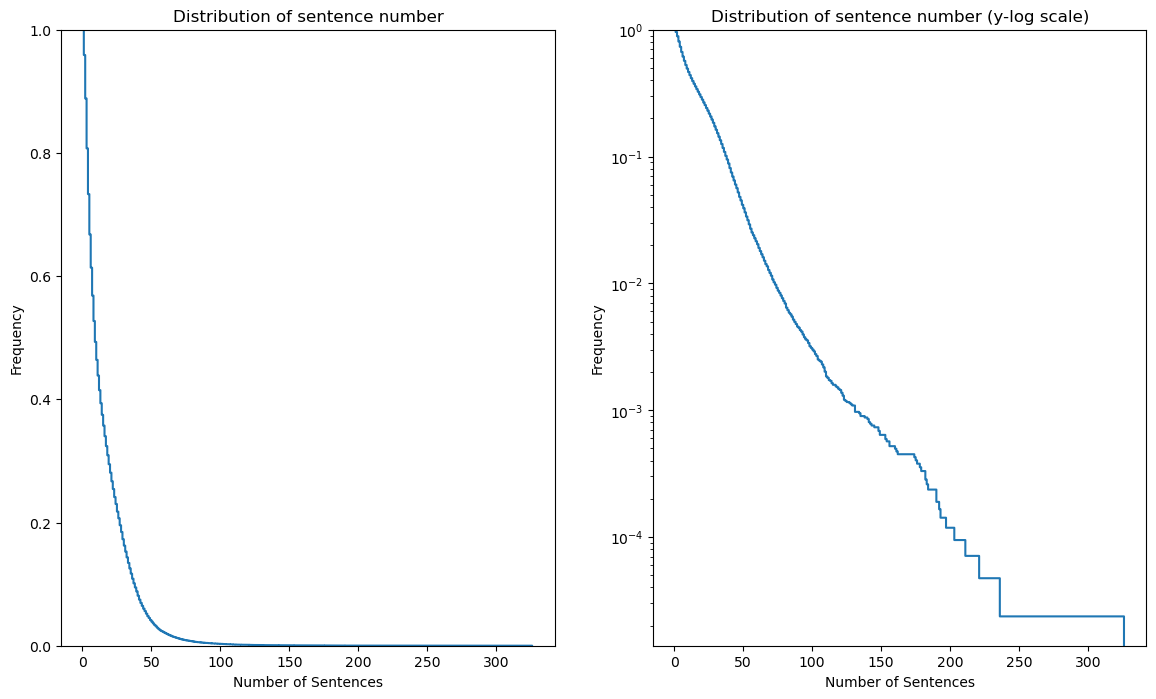

In [45]:
#visualize the number of sentences by drawing ccdf
fig, axes = plt.subplots(1, 2, figsize=(14,8))
sns.ecdfplot(plotsdf["Sentence_num"], ax=axes[0], complementary=True)
axes[0].set_title("Distribution of sentence number")
axes[0].set_xlabel("Number of Sentences")
axes[0].set_ylabel("Frequency")

#y axis in log scale
sns.ecdfplot(plotsdf["Sentence_num"], ax=axes[1], complementary=True)
axes[1].set_title("Distribution of sentence number (y-log scale)")
axes[1].set_xlabel("Number of Sentences")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")

Text(0.5, 0, 'Number of Sentences')

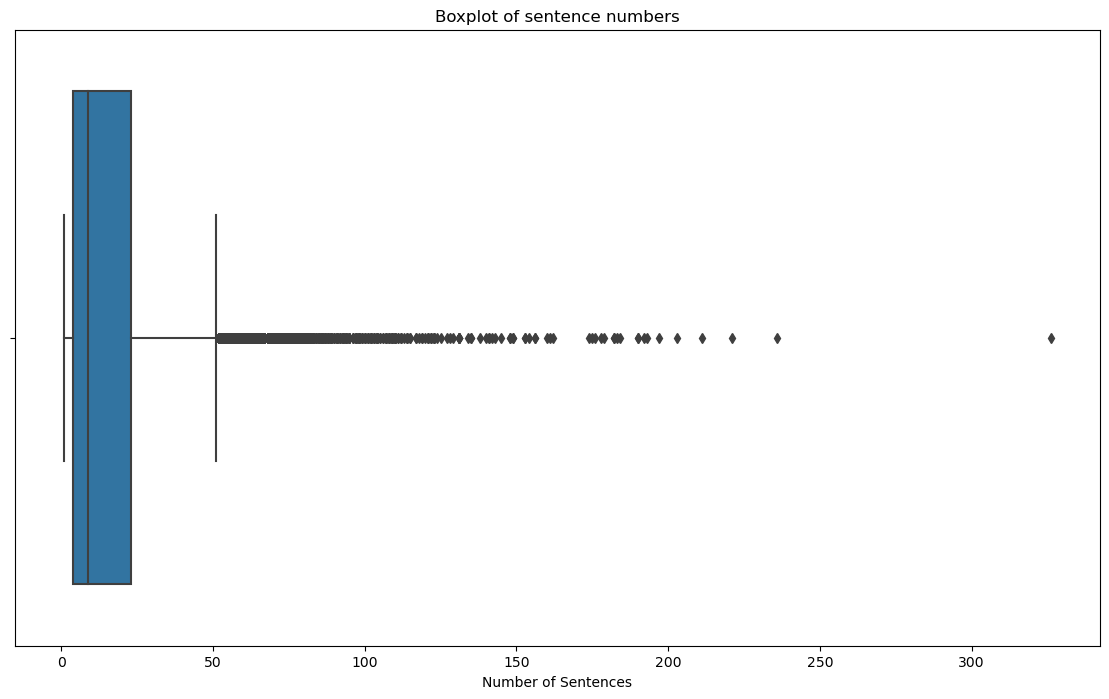

In [49]:
# Boxplot for the number of sentences
plt.figure(figsize=(14,8))
sns.boxplot(x=plotsdf["Sentence_num"])
plt.title("Boxplot of sentence numbers")
plt.xlabel("Number of Sentences")

In [65]:
#get the statistics in numerical values
print("Regarding the number of sentences:")
plotsdf["Sentence_num"].describe()

Regarding the number of sentences:


count    42303.000000
mean        15.768716
std         16.665825
min          1.000000
25%          4.000000
50%          9.000000
75%         23.000000
max        326.000000
Name: Sentence_num, dtype: float64

**Comment:** First, we see that the total number of sentences follows an exponential distribution. The majority of plots contain less than 9 sentences (3rd quartile). Half of the plots contain at least 0 sentences. To increase our processing speed while maintaining an acceptable amount of information, we will most likely filter by sentence number or rather by a metric of sentence number: we will check the number of words per sentence and we will also do a genrewise comparison before committing a definite filtering treshold.

In [66]:
#create column for number of words per sentence
plotsdf["word_per_sent"] = plotsdf["Word_num"]/plotsdf["Sentence_num"]

#get the statistics in numerical value
print("Regarding the number of words per sentence")
plotsdf["word_per_sent"].describe()

Regarding the number of words per sentence


count    42303.000000
mean        21.345132
std          6.373043
min          1.875000
25%         17.416667
50%         20.400000
75%         24.000000
max        227.000000
Name: word_per_sent, dtype: float64

**Comment:** The above statistics are interesting. While they do not provide much information, the minimum value tells us that there is a plot in which each sentence averages less than 2 words. We will print it to better look at it and get an idea of the plots quality in case of additional preprocessing required. We must also have a better look regarding the word per sentence count, especially for low sentence numbers (in that case we know for example that if a plot has only 2 sentences that average to 5 words per sentence, there would be no real point in keeping it for analysis)

In [74]:
#get the plot with fewest number of words per sentence
min_words_index = plotsdf["word_per_sent"].idxmin()

print("Selected outlier:")
print(plotsdf.loc[min_words_index])
print("\nPlot of outlier:", plotsdf.loc[min_words_index, "Plot"])

Selected outlier:
Wikipedia_movie_ID                                             33109159
Plot                   * Ashok Kumar * Nalini Jaywant * Pran * Durga...
Sentence_num                                                          8
Word_num                                                             15
word_per_sent                                                     1.875
Name: 17593, dtype: object

Plot of outlier:  * Ashok Kumar * Nalini Jaywant * Pran * Durga Khote * Ramayan Tiwari * Cukoo * Sulochana Latkar * Yakub * Kamal


We will delete this outlier. We also now know what to expect. It seems that filtering by words per sentence would be somewhat safer than simply filtering by sentence number. Further, we may have to consider filtering by language. The reason is that the tokenizer model we're using is an english model and further natural language processing will yield wrong results if used with non-english languages. We will have to reopen a general movies analysis parenthesis to check how many movies are deleted.

In [75]:
#delete outlier
plotsdf = plotsdf.drop(min_words_index)

We will proceed to look at the distribution of the number of words per sentence in plots containing 1 to 9 sentences.

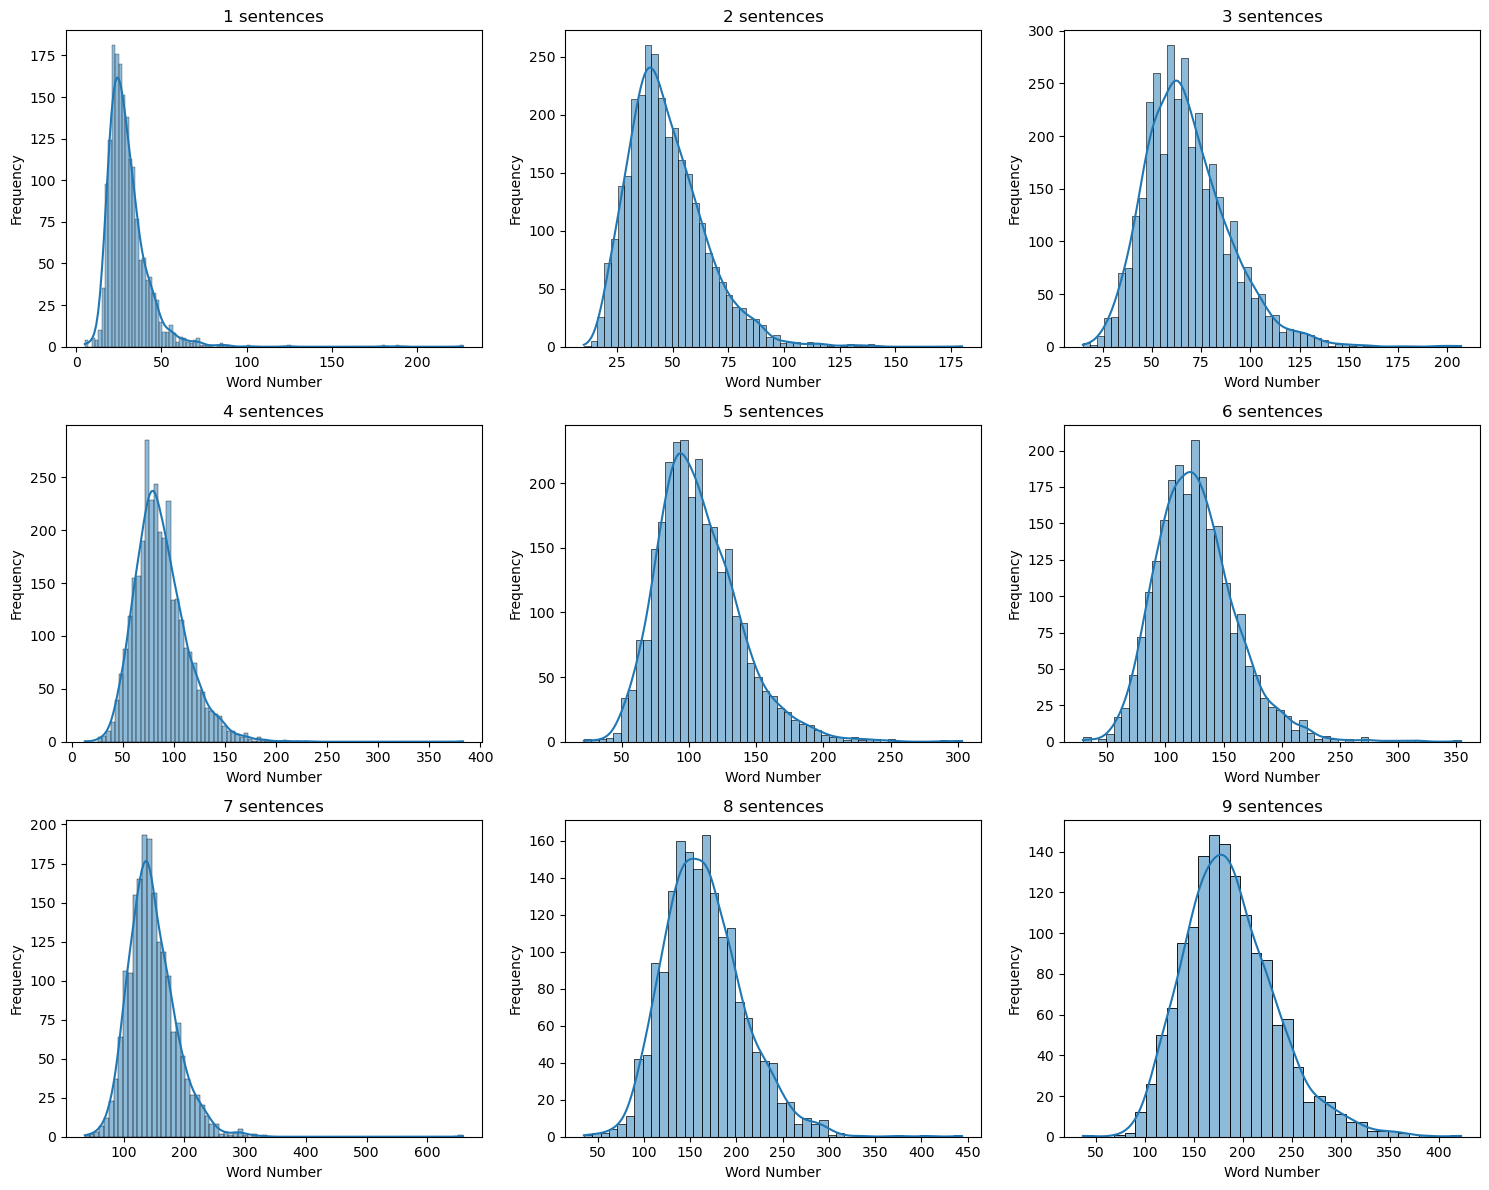

In [76]:
#create lists to store mean and median word per sentence (wps)
mean_wps_onetonine = []
median_wps_onetonine = []

#plot distributions
fig, axis = plt.subplots(3, 3, figsize=(15,12))

#loop over sentence number
for num_sentences in range(1,10):
    #filter for sentence number and keep only word number
    regionofinterest = plotsdf[plotsdf["Sentence_num"]==num_sentences]["Word_num"]
    
    #generate location in subplot
    row = (num_sentences-1)//3
    col = (num_sentences-1)%3

    #create histogram
    sns.histplot(regionofinterest, ax=axis[row,col], kde=True)
    
    #update lists
    mean_wps_onetonine.append(regionofinterest.mean())
    median_wps_onetonine.append(regionofinterest.median())
    
    #titles and axis
    axis[row,col].set_title(f"{num_sentences} sentences")
    axis[row,col].set_xlabel("Word Number")
    axis[row,col].set_ylabel("Frequency")
    
plt.tight_layout()

In [79]:
#print medians and means of number of words per sentence
for i in range(9):
    print(f"In plots with: {i+1} sentences there is on average: {mean_wps_onetonine[i]} words.")
    print(f"In plots with: {i+1} sentences, half of them have : {median_wps_onetonine[i]} words or less.\n")

In plots with: 1 sentences there is on average: 29.927461139896373 words.
In plots with: 1 sentences, half of them have : 27.0 words or less.

In plots with: 2 sentences there is on average: 47.30787269681742 words.
In plots with: 2 sentences, half of them have : 44.0 words or less.

In plots with: 3 sentences there is on average: 67.93115519253209 words.
In plots with: 3 sentences, half of them have : 65.0 words or less.

In plots with: 4 sentences there is on average: 87.37380497131932 words.
In plots with: 4 sentences, half of them have : 84.0 words or less.

In plots with: 5 sentences there is on average: 107.35642135642135 words.
In plots with: 5 sentences, half of them have : 103.0 words or less.

In plots with: 6 sentences there is on average: 126.48092941692241 words.
In plots with: 6 sentences, half of them have : 123.0 words or less.

In plots with: 7 sentences there is on average: 146.94835680751174 words.
In plots with: 7 sentences, half of them have : 142.0 words or less.


**Comment:** It is actually quite interesting. The distributions themselves become more and more Gaussian as the number of sentences increases. When see that even when the number of sentences is bigger, some are scarce in wording. These will be filtered out.

## Parenthesis on Languages 

Let's have a look at the different languages in the movie dataset and use this information to filter out movie plots that are not from english movies. We will do so by following an approach similar to that used for genres.

In [80]:
#take the languages column as a list
moviesdf["Movie_languages"] = moviesdf["Movie_languages"].apply(ast.literal_eval)

#make dictionary of all genres to count them
language_counts = {}

#loop over all rows
for _, row in moviesdf.iterrows():
    languages = row["Movie_languages"]
    
    #update dictionnary
    for language in languages:
        language_counts[language] = language_counts.get(language, 0) + 1

In [81]:
#print results
print(f"Total number of langages: {len(language_counts.keys())}")
for language, count in sorted(language_counts.items(), key=lambda x: x[1]):
    print(f"{language}: {count}")

Total number of langages: 203
Chewa language: 1
Picard Language: 1
Krio Language: 1
Sumerian: 1
Assyrian language: 1
Osetin Language: 1
Hmong language: 1
Tok Pisin Language: 1
Friulian Language: 1
Kuna language: 1
Papiamento language: 1
Korean Sign Language: 1
Kriolu: 1
Maasai Language: 1
Australian Aboriginal Pidgin English: 1
Guanzhong Hua: 1
Southwestern Mandarin: 1
Maninka language: 1
Deutsch: 1
Hazaragi Language: 1
Chhattisgarhi Language: 1
Cree language: 1
Judeo-Georgian Language: 1
Awadhi Language: 1
Aceh Language: 1
Cheyenne Language: 1
Sunda Language: 1
Venetian Language: 1
Banyumasan language: 1
Mohawk Language: 2
Italian: 2
Mende Language: 2
Apache, Western Language: 2
Aboriginal Malay languages: 2
Egyptian, Ancient: 2
Ancient Greek: 2
Scanian Language: 2
Algonquin Language: 2
Akan Language: 2
Teochew: 2
Japan: 2
Fulfulde, Adamawa Language: 2
Tulu Language: 2
Jamaican Creole English Language: 2
Hiligaynon language: 2
Classical Arabic: 2
Shanxi: 2
Frisian, Western Language: 2

**Comment:** It seems that a bit less than half of the movies are in english. That is good enough until we realize that we also have to check how often english movies appear in our plot dataframe. Note that we will not filter the main dataframe by language because the data itself would be relevant later on and our initial analysis is not language centered. We will now co-analyze language and plots.

_____

### Language and Plots

We will now start considering language in our plot filtering process. The filtering process sounds very convoluted but since we will use it to train a machine learning algorithm, it must be in the best shape possible.

In [84]:
#copy plots dataframe
plotlangenresdf = plotsdf.copy()

#merge to get genres and languages
plotlangenresdf = plotlangenresdf.merge(moviesdf[['Wikipedia_movie_ID','Movie_genres','Movie_languages']], how='left', on='Wikipedia_movie_ID')

print(f"Shape of the plot-language-genre dataframe: {plotlangenresdf.shape}")
plotlangenresdf.head(3)

Shape of the plot-language-genre dataframe: (42302, 7)


,Wikipedia_movie_ID,Plot,Sentence_num,Word_num,word_per_sent,Movie_genres,Movie_languages
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",1,28,28.000000,"[Drama, World cinema]",[Russian Language]
1,31186339,The nation of Panem consists of a wealthy Capi...,52,791,15.211538,"[Drama, Action/Adventure, Action, Science Fict...",[English Language]
2,20663735,Poovalli Induchoodan is sentenced for six yea...,26,501,19.269231,"[Musical, Bollywood, Drama, Action]",[Malayalam Language]


In [92]:
#replace NaNs in language with empty lists and count them
plotlangenresdf["Movie_languages"] = plotlangenresdf["Movie_languages"].apply(lambda x: x if isinstance(x, list) else [])
plots_zerolang = plotlangenresdf["Movie_languages"].apply(lambda x: len(x) == 0).sum()

print(f"There are {plots_zerolang} plots where language is unspecified.")
print(f"This represents {100*plots_zerolang/plotlangenresdf.shape[0]}% of the data.")

There are 7262 plots where language is unspecified.
This represents 17.167037019526262% of the data.


In [96]:
#check for NaNs in genres
plotlangenresdf["Movie_genres"].isna().sum()

3403

It seems that we have extra plots for movies that do not exist in the dataframe. Normally, most of them would also have no language associated to them. In this case, it is safe to just drop those rows.

In [100]:
#drop movies without genres
plotlangenresdf.dropna(subset=["Movie_genres"], inplace=True)
plotlangenresdf.shape

(38899, 7)

In [102]:
#count the occurrence of each language and genre
plots_languagescount = {}
plots_genrescount = {}

#loop over all rows
for _, row in plotlangenresdf.iterrows():
    languages = row["Movie_languages"]
    genres = row["Movie_genres"]
    
    #deal with empty language lists
    if languages == []:
        languages = ['unknown']

    #update dictionnaries
    for language in languages:
        plots_languagescount[language] = plots_languagescount.get(language, 0) + 1
    
    for genre in genres:
        plots_genrescount[genre] = plots_genrescount.get(genre,0) + 1

print(f"Number of different genres: {len(plots_genrescount.keys())}")
print(f"Number of different languages: {len(plots_languagescount.keys())}")

38899
Number of different genres: 363
Number of different languages: 203


Even more surprising, it seems that all genres are represented in the dataset. But one language is not.

In [109]:
#print the count of languages
for language, count in sorted(plots_languagescount.items(), key=lambda x: x[1]):
    print(f"{language}: {count}")

Cree language: 1
Maasai Language: 1
Hungary: 1
Deutsch: 1
Picard Language: 1
Assyrian language: 1
Hazaragi Language: 1
Venetian Language: 1
Chhattisgarhi Language: 1
Hmong language: 1
Tulu Language: 1
Haryanvi Language: 1
Kriolu: 1
Friulian Language: 1
Italian: 1
Osetin Language: 1
Shanxi: 1
Judeo-Georgian Language: 1
Awadhi Language: 1
Krio Language: 1
Maninka language: 1
Sunda Language: 1
Tzotzil language: 1
Kuna language: 1
Dzongkha Language: 1
Papiamento language: 1
Hariyani: 1
Guanzhong Hua: 1
Southwestern Mandarin: 1
Cheyenne Language: 1
Australian Aboriginal Pidgin English: 1
Korean Sign Language: 1
Chewa language: 1
Sumerian: 1
Gumatj Language: 1
Frisian, Western Language: 1
Tok Pisin Language: 1
Banyumasan language: 1
Crow Language: 2
Saami, North Language: 2
Aboriginal Malay languages: 2
Mohawk Language: 2
Algonquin Language: 2
Jamaican Creole English Language: 2
Teochew: 2
Napoletano-Calabrese Language: 2
Chechen Language: 2
Classical Arabic: 2
Hinglish: 2
Corsican Language:

**Comment:** In this case, there are enough english movies to be considered a good enough sample size for training. We will just check genre repartition after dropping all movies that are not in the english language.

In [110]:
#print the count of genres
for genre, count in sorted(plots_genrescount.items(), key=lambda x: x[1]):
    print(f"{genre}: {count}")

War effort: 1
Patriotic film: 1
Ninja movie: 1
Political Documetary: 1
Period Horror: 1
Linguistics: 1
Revisionist Fairy Tale: 1
Romantic thriller: 1
C-Movie: 1
Breakdance: 1
Chick flick: 1
New Queer Cinema: 1
Buddy Picture: 1
Comdedy: 1
Statutory rape: 1
Historical Documentaries: 1
Silhouette animation: 1
Children's Issues: 1
Homoeroticism: 1
Neorealism: 1
The Netherlands in World War II: 2
Film-Opera: 2
Prison escape: 2
Live action: 2
Conspiracy fiction: 2
Bruceploitation: 2
Revenge: 2
Z movie: 2
Beach Party film: 2
Private military company: 2
Tokusatsu: 2
Expressionism: 2
Anthropology: 2
Star vehicle: 2
Clay animation: 2
Journalism: 2
Supermarionation: 2
Early Black Cinema: 3
Education: 3
Singing cowboy: 3
Camp: 3
Bloopers & Candid Camera: 3
Point of view shot: 3
Race movie: 3
Cyberpunk: 3
Health & Fitness: 3
Filmed Play: 3
Plague: 3
Latino: 3
Nuclear warfare: 3
Psychological horror: 3
Vampire movies: 3
Operetta: 4
Sci Fi Pictures original films: 4
Graphic & Applied Arts: 4
Alien in

**Comment:** Sadly, it seems that our dataset is somewhat skewed since the genres we are interested in are not so balanced: Barbie is a comedy, fantasy adventure (total roughly 18000 occurrences, not counting compound genres) whereas Oppenheimer is more of a drama, historical documentary, borderline thriller (19000 occurrences if we ignore thrillers, 25000 with thrillers). We will have to further merge the genres before continuing. We will store the genre counts in a dataframe and create a column for before and after filtering for the english language to check if the difference is statistically significant and for which genres. We will choose our training set after doing this assessment. 

In [117]:
#store genre count in a dataframe
plotsgenredf = pd.DataFrame(list(plots_genrescount.items()), columns=["Genre","Count_Before_Filtering"])
plotsgenredf.head(3)

,Genre,Count_Before_Filtering
0,Drama,18084
1,World cinema,5058
2,Action/Adventure,3443


In [114]:
#copying dataframe
englishplotlangenresdf = plotlangenresdf.copy()

#dropping all non-english movies
englishplotlangenresdf = englishplotlangenresdf[englishplotlangenresdf["Movie_languages"].apply(lambda x: "English Language" in x)]

In [115]:
#confirming succesfull filtration
englishplotlangenresdf.shape

(23880, 7)

In [116]:
#counting genre occurences again
#creating new dictionnary
genre_counts_plot_eng = {}

#iterrating over all rows
for _, row in englishplotlangenresdf.iterrows():
    genres = row["Movie_genres"]
    
    #updating dictionary
    for genre in genres:
        genre_counts_plot_eng[genre] = genre_counts_plot_eng.get(genre,0) + 1

#print length of new dictionnary
print(f"Number of genres post filtration: {len(genre_counts_plot_eng.keys())}")

Number of genres post filtration: 349


In [118]:
#create new dataframe
genrecounts_afterfiltrationdf = pd.DataFrame(list(genre_counts_plot_eng.items()), columns=["Genre","Count_After_Filtering"])

In [119]:
#merge dataframes
plotsgenredf = plotsgenredf.merge(genrecounts_afterfiltrationdf, how = 'left', on="Genre")

plotsgenredf.head()

,Genre,Count_Before_Filtering,Count_After_Filtering
0,Drama,18084,10517.0
1,World cinema,5058,1099.0
2,Action/Adventure,3443,2585.0
3,Action,5494,3496.0
4,Science Fiction,2194,1749.0


In [121]:
#Replace NaNs with 0
plotsgenredf = plotsgenredf.fillna(0)

#print the 20 genres that disappeared
plotsgenredf.loc[plotsgenredf["Count_After_Filtering"]==0]

,Genre,Count_Before_Filtering,Count_After_Filtering
124,Tamil cinema,63,0.0
142,Tollywood,31,0.0
210,Pinku eiga,20,0.0
271,Malayalam Cinema,12,0.0
304,Bruceploitation,2,0.0
307,Czechoslovak New Wave,6,0.0
313,Revenge,2,0.0
333,Political Documetary,1,0.0
335,Tokusatsu,2,0.0
343,Romantic thriller,1,0.0


We will conduct a Wilcoxon signed rank test to test the statistical significance of our filtering.

In [163]:
#conduct wilcoxon test
stats.wilcoxon(plotsgenredf["Count_Before_Filtering"], plotsgenredf["Count_After_Filtering"])

WilcoxonResult(statistic=0.0, pvalue=6.89376886090984e-48)

The distributions are quite different, our filtering had a pretty big effect. It means that we may want to reconsider language filtering when training a machine learning model.

Finally, we will now check the distribution of sentence number in this new dataset and words per sentence statistics to check if this is enough filtering.

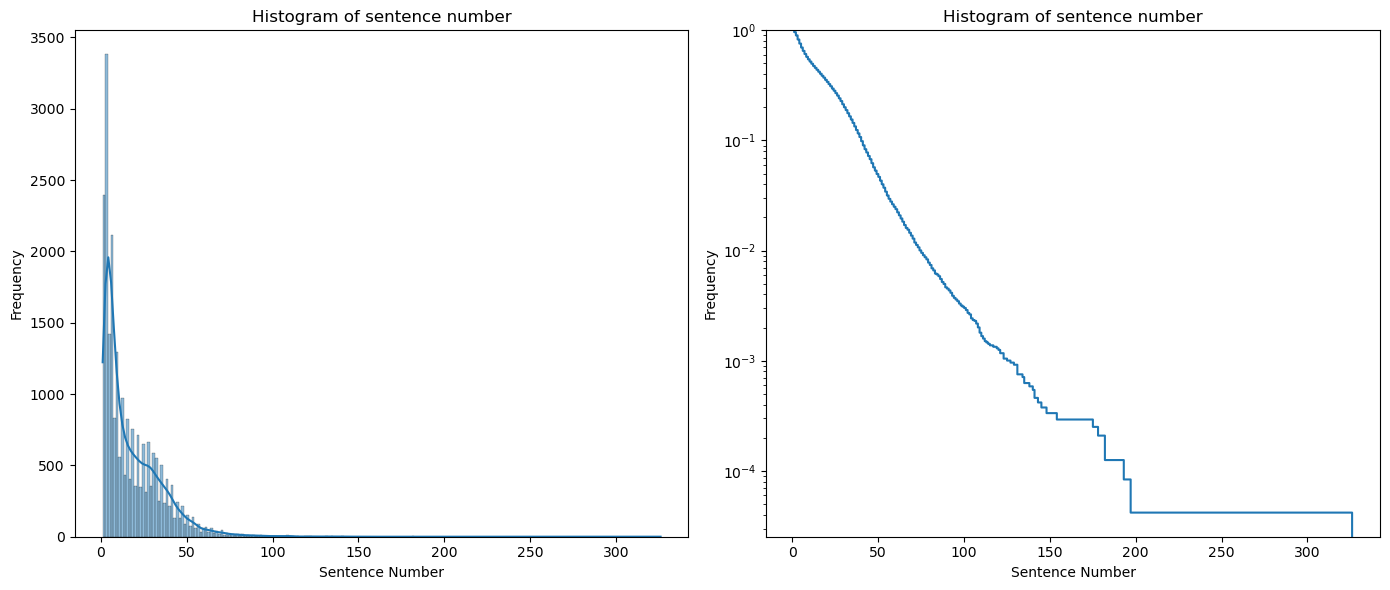

In [182]:
#histogram of sentence number
fig, axe = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(data=englishplotlangenresdf["Sentence_num"], kde=True, ax=axe[0] )
axe[0].set_title("Histogram of sentence number")
axe[0].set_xlabel("Sentence Number")
axe[0].set_ylabel("Frequency")

sns.ecdfplot(data=englishplotlangenresdf["Sentence_num"], complementary=True, ax=axe[1] )
axe[1].set_title("Histogram of sentence number")
axe[1].set_xlabel("Sentence Number")
axe[1].set_ylabel("Frequency")
axe[1].set_yscale('log')

plt.tight_layout()

In [183]:
#get statistics for sentence number
englishplotlangenresdf["Sentence_num"].describe()

count    23880.000000
mean        17.644849
std         17.284296
min          1.000000
25%          5.000000
50%         11.000000
75%         27.000000
max        326.000000
Name: Sentence_num, dtype: float64

In [184]:
#get statistics for words per sentence
englishplotlangenresdf["word_per_sent"].describe()

count    23880.000000
mean        21.940909
std          5.915929
min          2.090909
25%         18.135135
50%         21.000000
75%         24.500000
max        124.000000
Name: word_per_sent, dtype: float64

**Comment:** After looking at sentence distribution and the number of words per sentence. We see that:
 - The distribution of sentence number is exponential.
 - Our number of words per sentence is still lacking but we're really good: we have some outliers with less than 3 words per sentence which we must remove but the first quartile is 17 words per sentence which is not too far off from the limit set by the UK government [link](https://insidegovuk.blog.gov.uk/2014/08/04/sentence-length-why-25-words-is-our-limit/).

We will conduct one last filtering step where we remove everything with less than 8 words per sentence (subject, verb, object + 2 determinants, 2 adjectives, 1 adverb) after checking the outlier.

In [186]:
#check outlier
min_index = englishplotlangenresdf["word_per_sent"].idxmin()

print("Outlier:")
print(englishplotlangenresdf.loc[min_index])
print("\nPlot of outlier:", englishplotlangenresdf.loc[min_index, "Plot"])

Outlier:
Wikipedia_movie_ID                                              9627851
Plot                   * China Zorrilla ... Mamá * Eduardo Blanco .....
Sentence_num                                                         22
Word_num                                                             46
word_per_sent                                                  2.090909
Movie_genres                [Comedy, Drama, Family Drama, World cinema]
Movie_languages                    [Spanish Language, English Language]
Name: 20536, dtype: object

Plot of outlier:  * China Zorrilla ... Mamá * Eduardo Blanco ... Jaime * Ulises Dumont ... Gregorio * Silvina Bosco ... Dorita * Floria Bloise ... Lucrecia * Nicolás Condito ... Chico * Tito Mendoza ... Enfermero  * Pascual Condito .... producer * Luisa Matienzo .... producer * Santiago Carlos Oves.... producer * Carlos Piwowarski .... associate producer * Jorge Piwowarski .... associate producer * Mónica Roza .... executive producer/producer


In [188]:
#check outlier for sentence number
min_index = englishplotlangenresdf["Sentence_num"].idxmin()

print("Outlier:")
print(englishplotlangenresdf.loc[min_index])
print("\nPlot of outlier:", englishplotlangenresdf.loc[min_index, "Plot"])

Outlier:
Wikipedia_movie_ID                                             25755313
Plot                  The sequel to the TV movie entitled The Incide...
Sentence_num                                                          1
Word_num                                                             49
word_per_sent                                                      49.0
Movie_genres                                                    [Drama]
Movie_languages                                      [English Language]
Name: 50, dtype: object

Plot of outlier: The sequel to the TV movie entitled The Incident, a small-town lawyer, Harmon Cobb, and his family move to Baltimore where he becomes the law partner of his old adversary, where he goes against the State of Maryland, suing on behalf of an institutionalized mental patient for release.http://www.tcm.com/tcmdb/title.jsp?stid=456508


In [187]:
#remove everything with less than 8 words per sentence
finalplotfiltered = englishplotlangenresdf.copy()
finalplotfiltered = finalplotfiltered[finalplotfiltered["word_per_sent"]>8]

display(finalplotfiltered)

,Wikipedia_movie_ID,Plot,Sentence_num,Word_num,word_per_sent,Movie_genres,Movie_languages
1,31186339,The nation of Panem consists of a wealthy Capi...,52,791,15.211538,"[Drama, Action/Adventure, Action, Science Fict...",[English Language]
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",49,870,17.755102,"[Comedy, Screwball comedy]",[English Language]
4,595909,Seventh-day Adventist Church pastor Michael Ch...,15,408,27.200000,"[Courtroom Drama, Drama, Crime Fiction, World ...",[English Language]
5,5272176,The president is on his way to give a speech. ...,27,347,12.851852,"[Drama, Action/Adventure, Action, Thriller]",[English Language]
6,1952976,"{{plot}} The film opens in 1974, as a young gi...",45,776,17.244444,"[Horror, Drama, Thriller]",[English Language]
...,...,...,...,...,...,...,...
42294,29046736,Lucy is working as a dancer in a sleazy strip...,49,891,18.183673,[Horror],[English Language]
42296,2867597,"An attempt to bring the famed ""Mr. Bill"" clay ...",3,128,42.666667,"[Comedy, Slapstick]",[English Language]
42298,1096473,"In 1928 Hollywood, director Leo Andreyev look...",31,528,17.032258,"[Indie, Drama, Black-and-white, Period piece, ...","[English Language, Silent film]"
42299,35102018,American Luthier focuses on Randy Parsons’ tra...,6,161,26.833333,"[Short Film, Music, Documentary, Biographical ...",[English Language]


____

### On Actors

In this section, we will just gather general information on actors.

In [189]:
#show head to remember dataframe
charactersdf.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [203]:
#height statistics
charactersdf["Actor_height"].describe()

count    154824.000000
mean          1.788893
std           4.379940
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max         510.000000
Name: Actor_height, dtype: float64

It seems we have some pretty big outlier. We will have to either correct the heights or change them to NaNs.

In [205]:
#change outliers to NaNs
charactersdf["Actor_height"] = charactersdf["Actor_height"].apply(lambda x: np.nan if x>3 else x)

In [206]:
#new height statistics
charactersdf["Actor_height"].describe()

count    154809.000000
mean          1.748177
std           0.106249
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max           2.356000
Name: Actor_height, dtype: float64

We will do the same for ages.

In [207]:
charactersdf["Actor_age_at_movie_release"].describe()

count    292556.000000
mean         37.788523
std          20.587870
min       -7896.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Actor_age_at_movie_release, dtype: float64

In [209]:
#count number of NaNs in release year and actor birth date
char_noreleaseyear = charactersdf["Movie_release_date"].isna().sum()
char_noactorbirthday = charactersdf["Actor_date_of_birth"].isna().sum()

#count number of 0 or negative values in actor age
char_wrongactorage = (charactersdf["Actor_age_at_movie_release"]<1).sum()

#count number of missing ages
char_noactorage = charactersdf["Actor_age_at_movie_release"].isna().sum()

print(f"There are {char_noreleaseyear} missing release dates.")
print(f"There are {char_noactorbirthday} characters missing actor birth dates.")
print(f"There are {char_wrongactorage} actors who have ages of 0 or less.")
print(f"There are {char_noactorage} actors whose age at movie release are not mentioned.")

There are 9995 missing release dates.
There are 106145 characters missing actor birth dates.
There are 433 actors who have ages of 0 or less.
There are 158113 actors whose age at movie release are not mentioned.


We will set all ages that are 0 or less to NaNs.

In [210]:
#remove ages of 0 or less
charactersdf["Actor_age_at_movie_release"] = charactersdf["Actor_age_at_movie_release"].apply(lambda x:np.nan if x<1 else x)

C:\Users\andre\AppData\Local\Temp\ipykernel_13640\958789321.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

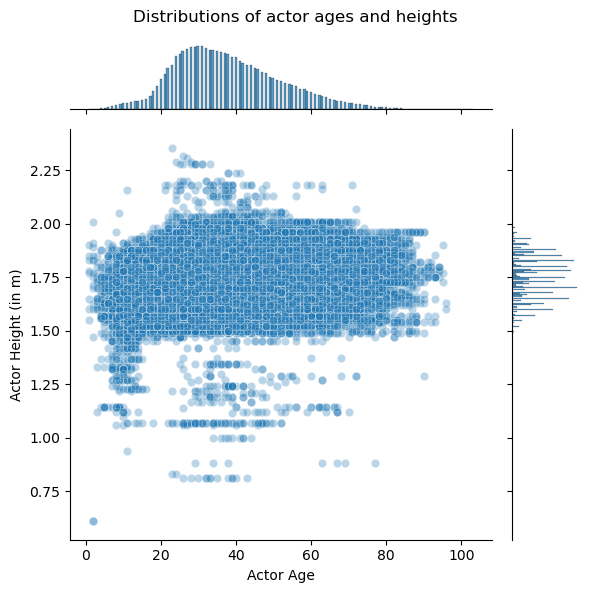

In [224]:
#look at age vs height distributions:
plt.figure(figsize=(14,8))
sns.jointplot(x="Actor_age_at_movie_release", y="Actor_height", data=charactersdf, alpha=0.3)
plt.xlabel("Actor Age")
plt.ylabel("Actor Height (in m)")
plt.suptitle("Distributions of actor ages and heights")
plt.tight_layout()

At first, it may look like we have 3 sorts of outliers:
 - Child Actors
 - Actors with wrong ages
 - Actors with wrong heights
 
The first is not wrong data. The "wrong heights" is not necessarily wrong either it may just be actors like Warwick Davis. For taller actors, it is not necessarily a problem. The actual outliers are the ones below 10 years old who are already as tall as adults. We know very few actors with such characetristics if any.

In [225]:
#set age of actors with high heights but low age (<10) to nan
charactersdf.loc[(charactersdf['Actor_height'] > 1.5) & (charactersdf['Actor_age_at_movie_release'] < 10),'Actor_age_at_movie_release'] = np.nan

In [227]:
#create a movie release year column
charactersdf['Release_year'] = pd.to_datetime(charactersdf['Movie_release_date'], errors='coerce').dt.year
charactersdf.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0


In [233]:
# Calculate the number of unique ethnicities for each movie and create a new column
charactersdf['Num_Ethnicities_Per_Movie'] = charactersdf.groupby('Wikipedia_movie_ID')['Actor_ethnicity'].transform('nunique')

charactersdf.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year,Num_Ethnicities_Per_Movie
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,3
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,3
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,3
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,3
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,3


Text(0.5, 0, 'Year')

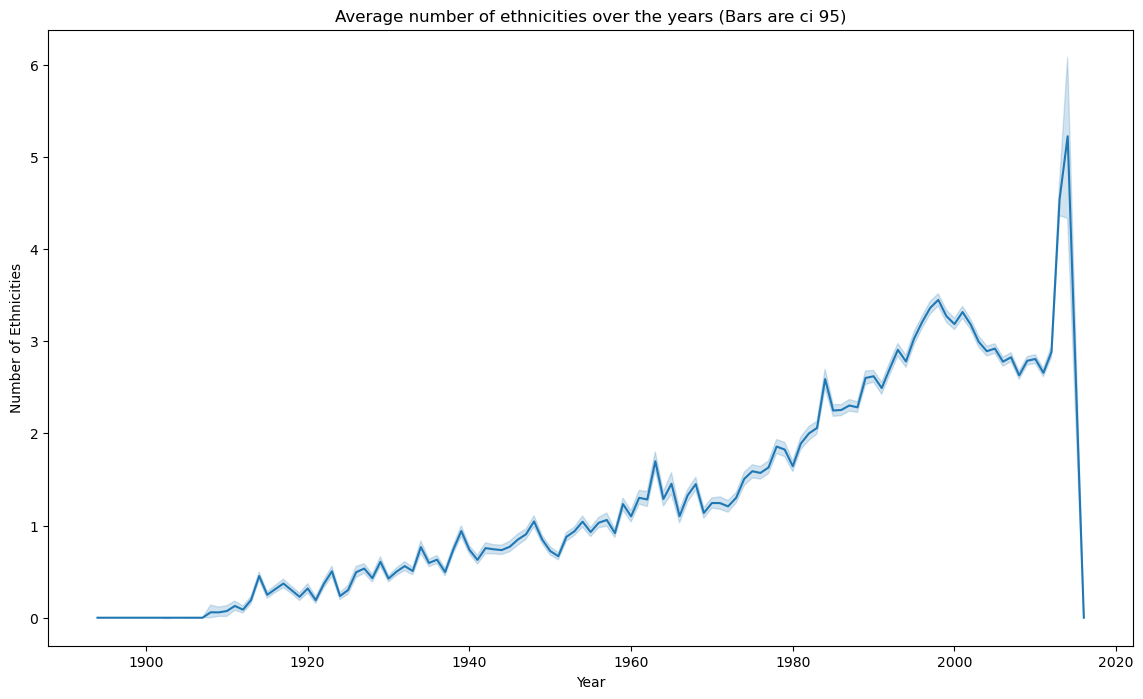

In [234]:
#plot average number of ethnicities over the years
plt.figure(figsize=(14,8))
sns.lineplot(data=charactersdf, x="Release_year", y='Num_Ethnicities_Per_Movie', errorbar= ('ci',95))
plt.title("Average number of ethnicities over the years (Bars are ci 95)")
plt.ylabel("Number of Ethnicities")
plt.xlabel("Year")

In [236]:
#there are some movies where there is 0 women so we create a helper function to deal with them
def calculate_male_to_female_ratio(group):
    male_count = (group == 'M').sum()
    female_count = (group == 'F').sum()
    
    return male_count / female_count if female_count != 0 else np.nan

# Calculate the male-to-female ratio
charactersdf['Male_To_Female_Ratio'] = charactersdf.groupby('Wikipedia_movie_ID')['Actor_gender'].transform(calculate_male_to_female_ratio)

Text(0.5, 0, 'Year')

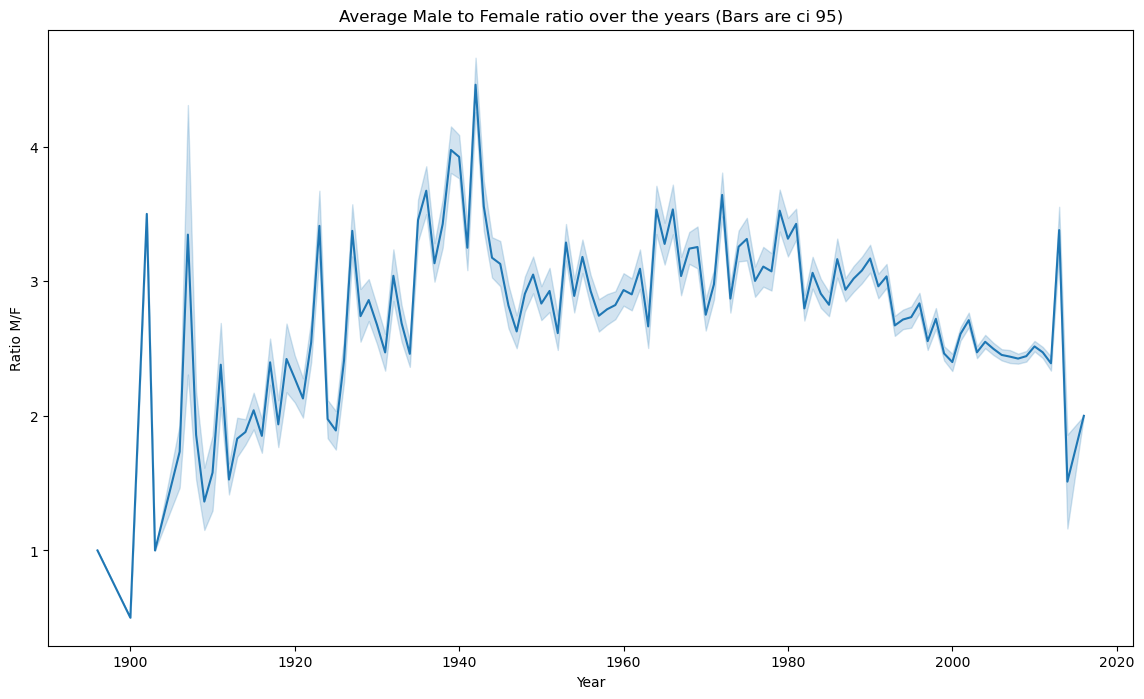

In [237]:
#plot average Male to female ratio over the years
plt.figure(figsize=(14,8))
sns.lineplot(data=charactersdf, x="Release_year", y='Male_To_Female_Ratio', errorbar= ('ci',95))
plt.title("Average Male to Female ratio over the years (Bars are ci 95)")
plt.ylabel("Ratio M/F")
plt.xlabel("Year")

________________ 

# Genre-plot analysis 

We will now do a sort of primary genre analysis. We will check the number of genres released per year. The number of movies they appear in, and their mean ratings. 

In [24]:
#create a smaller dataframe of only genres. It will be used later with the plots
#genresdf = 

In [238]:
import dill

In [239]:
all_vars = %who_ls
%store -r
dill.dump_session('notebook_state.db')
%store all_vars

Stored 'all_vars' (list)
